# Fireveg DB - plot of fire history per sampling location

Author: [José R. Ferrer-Paris](https://github.com/jrfep) and [Ada Sánchez-Mercado](https://github.com/adasanchez)

Date: July 2024

This Jupyter Notebook includes **R code to analyse and visualise** data exported from the Fireveg Database. 

Here we will read input from a public data record of the database to answer some questions about the data coverage of the database.

```mermaid
flowchart LR
    Litrev & Form  --> Fireveg --> DR --> Code --> Q1 & Q2 & Q3
    Fireveg[(Fireveg\nDatabase)]
    Litrev[Field work\ndata stream] 
    Form[Existing sources\n data stream] 
    BioNet(BioNet Atlas\nSpecies list) 
    BioNet -.-> Fireveg
    DR[Exported\nData Record\nVersion 1.1]
    Code{R code\nfor analysis}:::ThisRepo
    Q1[Q1. ...]
    Q2["Q2. ..."]
    Q3["Q3. Sampling related to time since fire"]:::ThisRepo      
classDef ThisRepo fill:none,stroke:black,color:black;

```

In this notebook we will explore the **timing of field visits in relation to time since fire disaggregated by surveys**.

## Set-up

### Load packages

In [1]:
library(ggplot2)
library(forcats)
library(dplyr)
library(data.table)
library(sf)
library(tidyr)
library(ozmaps)
library(ggrepel)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Warning message:
“package ‘sf’ was built under R version 4.3.3”
Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



### Paths for inputs and outputs

Set working directory

In [2]:
here::i_am("Notebooks/21-Fire-history-field-visits.ipynb")

here() starts at /Users/z3529065/proyectos/fireveg/fireveg-analysis



In [3]:
data_dir <- here::here("data")
if (!dir.exists(data_dir))
    dir.create(data_dir)

### Read data from local folder

<div class="alert alert-info">
     <img src='../img/open-data-2.png' width=25 alt="open data icon"/>
Data for this Notebook is available from the following OSF repository:

> Ferrer-Paris, J. R., Keith, D., & Sánchez-Mercado, A. (2024, August 15). Export data records from Fire Ecology Traits for Plants database. Retrieved from [osf.io/h96q2](https://osf.io/h96q2/)
</div>

See notebook [00-Data-download](00-Data-download.ipynb) for instructions on how to download the data programatically with R.

The data is now available in our local data folder and we can use `readRDS` to read these files into our R session, 

In [4]:
firehistory_table <- readRDS(here::here(data_dir,"fire-history.rds")) |> mutate(site_label=factor(site_label))
quadrats_table <- readRDS(here::here(data_dir,"Quadrat-sample-data.rds"))
visits_table <- readRDS(here::here(data_dir,"site-visits.rds"))

We use `read_sf` to read spatial vector data:

In [5]:
site_locs <- read_sf(here::here(data_dir,"field-sites.gpkg"))

## Visualisation of fire history

### Fire history table

The fire history table has this information (an example from one site):

In [6]:
firehistory_table |> filter(site_label %in% "AUSALPS_NSW038")

site_label,earliest_date,latest_date,how_inferred,cause_of_ignition
<fct>,<date>,<date>,<chr>,<chr>
AUSALPS_NSW038,2003-01-01,2003-12-31,NA,Lightning
AUSALPS_NSW038,2020-01-01,2020-01-31,NA,Lightning


The field visits table has this information for the same site:

In [7]:
visits_table |> filter(site_label %in% "AUSALPS_NSW038")

site_label,visit_date
<chr>,<date>
AUSALPS_NSW038,2021-11-01


This will help us calculate firehistory from the table:

In [8]:
site_visit_firehistory <- 
  firehistory_table |> 
  group_by(site_label) |>
  summarise(nfires=n(),
            first_fire=min(earliest_date),
            date1=max(earliest_date),date2=max(latest_date)) |>
  left_join(visits_table, by="site_label", relationship = "one-to-many") |>
  mutate(
    time_min=visit_date-date2, 
    time_max=visit_date-date1,
    month1=month(date1),
    month2=month(date2)) |>
  filter(time_min >= 0,time_max < 1000, month1==month2)  

This new table has the following information:

In [9]:
site_visit_firehistory |> filter(site_label %in% "AUSALPS_NSW038")

site_label,nfires,first_fire,date1,date2,visit_date,time_min,time_max,month1,month2
<chr>,<int>,<date>,<date>,<date>,<date>,<drtn>,<drtn>,<int>,<int>
AUSALPS_NSW038,2,2003-01-01,2020-01-01,2020-01-31,2021-11-01,640 days,670 days,1,1


And has information for this many records (unique field visits)

In [10]:
dim(firehistory_table)

[1] 275   5

### Fire history histogram

This is a simple histogram of time since last fire:

Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


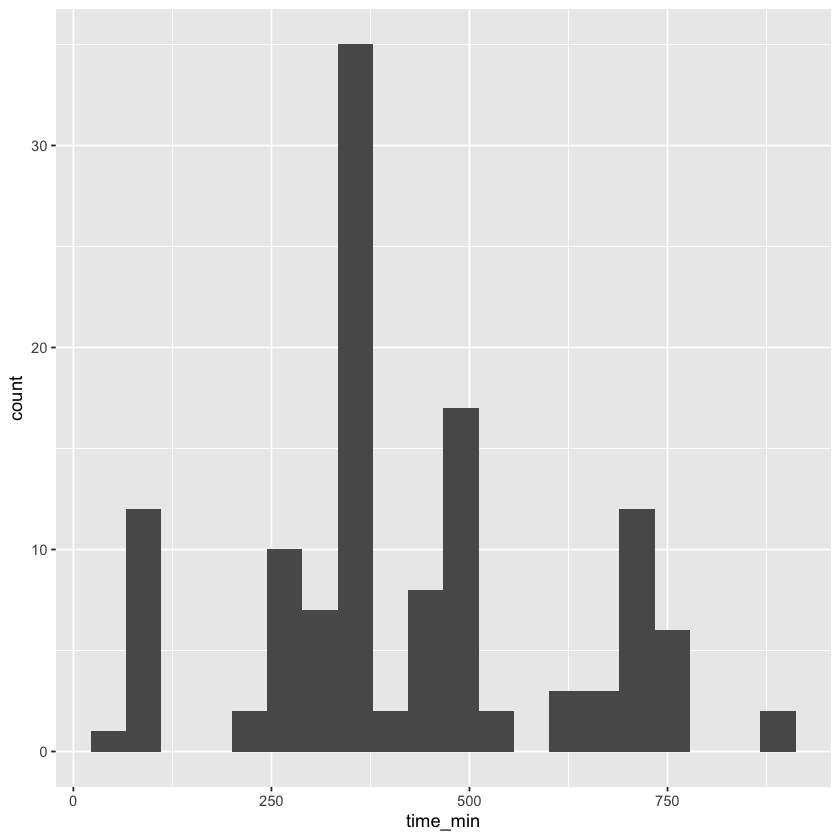

In [11]:
ggplot(site_visit_firehistory) +
    geom_histogram(aes(x=time_min), bins=20) 

Which ones have been visited in the first 100 days after the fire:

In [12]:
site_visit_firehistory |>
    filter(time_min <100)

site_label,nfires,first_fire,date1,date2,visit_date,time_min,time_max,month1,month2
<chr>,<int>,<date>,<date>,<date>,<date>,<drtn>,<drtn>,<int>,<int>
BS2,1,2020-01-01,2020-01-01,2020-01-01,2020-03-06,65 days,65 days,1,1
CW1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
CW2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
GGE1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
GGE2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
GGW1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
GGW2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-04,79 days,79 days,12,12
HV1,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12
HV2,1,2019-12-16,2019-12-16,2019-12-16,2020-03-05,80 days,80 days,12,12


### Regional differences

We have different time frames for the time series of visits in the Mallee Woodlands vs. the rest of the surveys in Eastern NSW. 
Let's visualise survey information in a map:

In [13]:
nsw <- st_transform(ozmaps::ozmap_states, 4326) %>% filter(NAME == "New South Wales")
okabe <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")

In [14]:
excluded <- c( "TO BE CLASSIFIED")
field_surveys <- site_locs |> 
         filter(!survey_name %in% excluded)

In [15]:
survey_cts <- field_surveys |> 
  group_by(survey_name,survey_description) |> 
  summarise(
    nsites=n(),
    geom=st_union(geom),.groups='keep') |> 
  st_centroid()
xys <- st_coordinates(survey_cts) |> data.frame()
xys$survey_name <- survey_cts$survey_name
xys$survey_desc <- survey_cts |> 
  transmute(
    description=sprintf(
      "%s\n%s sites",
      survey_description, nsites
      )) |>
  pull(description)


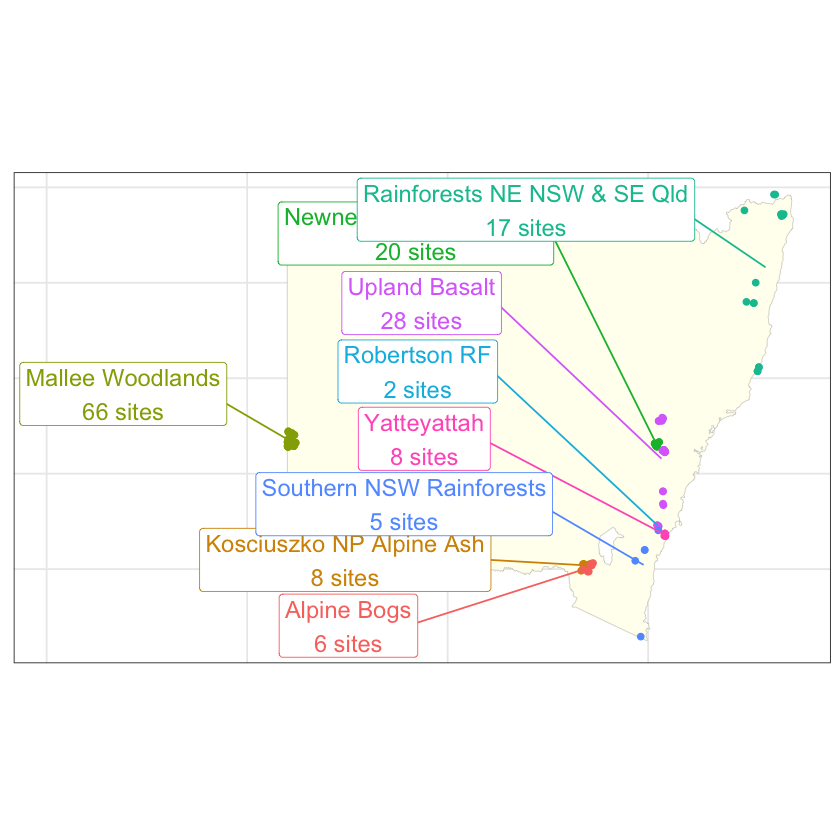

In [16]:
ggplot() + 
    geom_sf(data=nsw,fill='ivory1',colour='ivory3') +
    geom_sf(data=field_surveys,aes(colour=survey_name)) + 
  geom_label_repel(data=xys,
                   size=5,
                   nudge_x = -6,
                   nudge_y = 1,
                   direction = "y",
                aes(label=survey_desc
                    , colour=survey_name,x=X,y=Y)) +
  theme_bw() +
  theme(legend.position = "none",
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        )

Let's add the survey information to the dataframe and plot a histogram for each region:

In [17]:
excluded <- c( "TO BE CLASSIFIED")
site_visit_firehistory <- site_visit_firehistory |>
    mutate(survey_name = site_locs$survey_name[match(site_label, site_locs$site_label)]) |> 
         filter(!survey_name %in% excluded) |>
    mutate(survey_group = if_else(
        survey_name %in% "Mallee Woodlands",
            "Western NSW",
            "Eastern NSW"))

This plot only includes time since most recent fire:

Don't know how to automatically pick scale for object of type <difftime>. Defaulting to continuous.


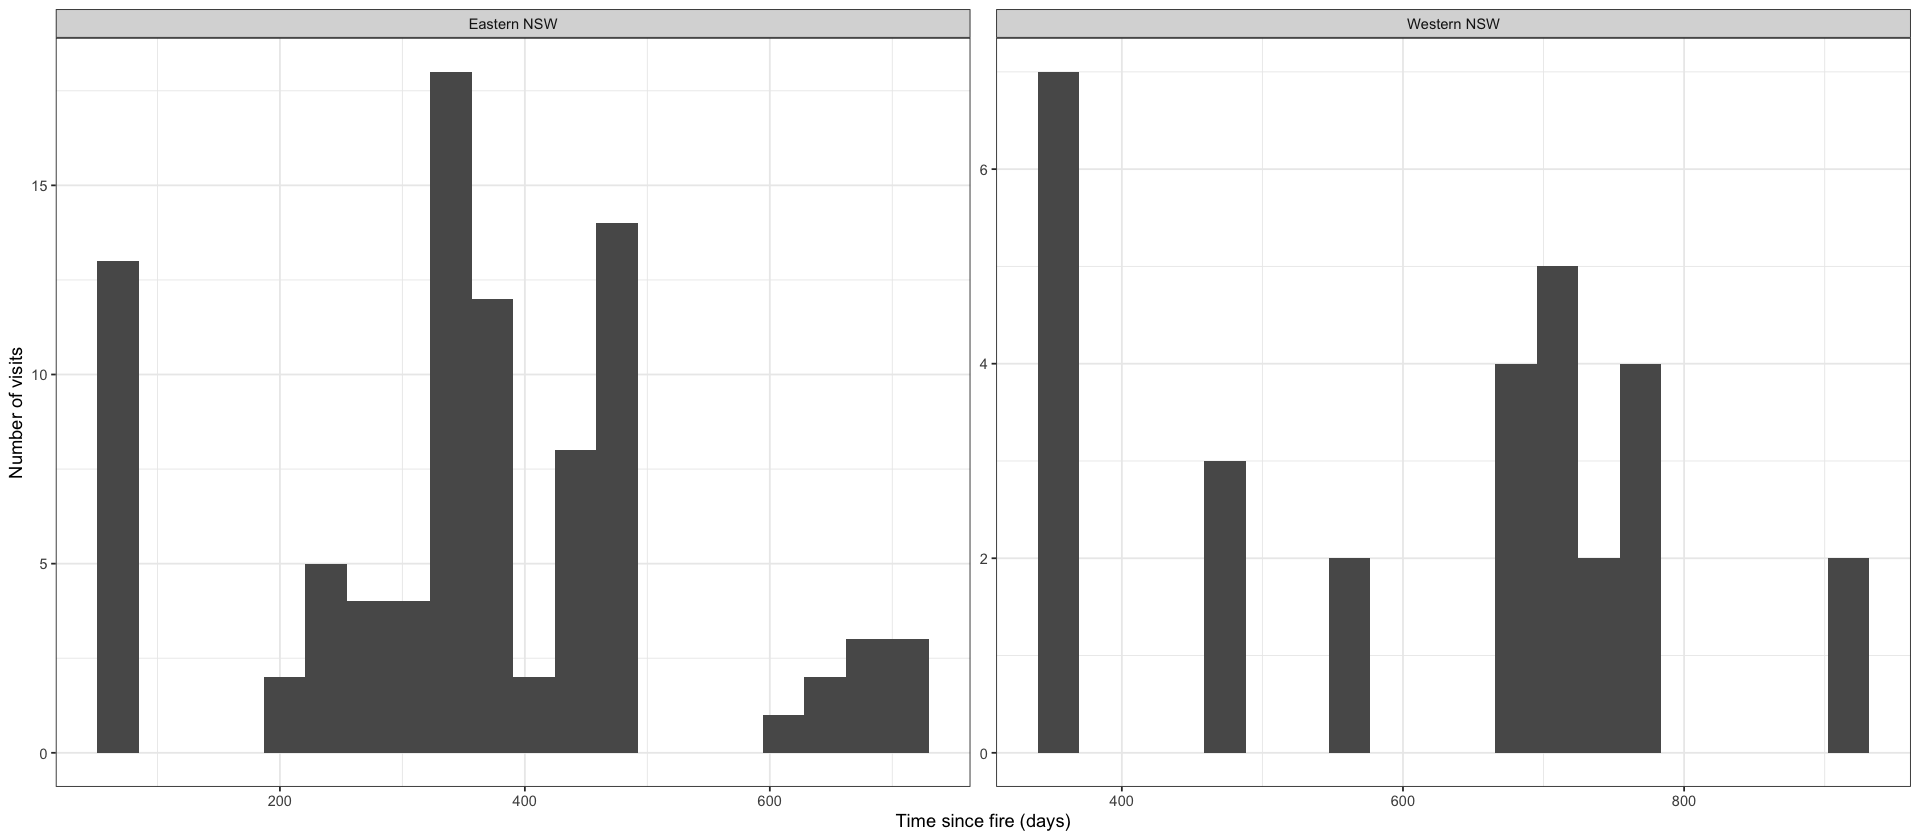

In [18]:
options(repr.plot.width=16) # Make plot larger

ggplot(site_visit_firehistory,
  aes(
    x = time_min,
  )) +
  geom_histogram(bins = 20) +
  facet_wrap(~ survey_group, scales ="free") +
  theme(legend.position = "none") +
  labs(x = "Time since fire (days)", y = "Number of visits") +
  theme_bw()

### Alternative visualisation of the fire history
This is another plot to look at the number of visits after fire events in each survey location.
We start with a common data frame

In [19]:
 fire_visits_data <- firehistory_table %>% 
  transmute(site_label,
    date = earliest_date,
    event = 'fire') |>
  bind_rows(
    visits_table |> 
      transmute(site_label,
      date = visit_date,
      event = 'visit')
    ) |>
  right_join(field_surveys |> st_drop_geometry(), 
             by="site_label", relationship="many-to-one") 

Then we split it in two:

In [20]:
fvd2 <- fire_visits_data |> 
  filter((survey_name %in% "Mallee Woodlands" & date > "2000-01-01"))
fvd1 <- fire_visits_data |>
  filter(!(survey_name %in% "Mallee Woodlands") & date > "2015-01-01") 

And create the plots for each subset of the data

In [21]:
fire1 <- ggplot(fvd1) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2019-10-01','2022-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )

In [22]:
fire2 <- ggplot(fvd2) + 
    geom_point(aes(x=date, y=site_label, colour=event)) +
  facet_grid(survey_name ~ ., scales="free", space="free") +
#  coord_polar(theta="y", start=0,direction=1) +
    coord_cartesian(xlim=as.Date(c('2000-10-01','2019-01-01'))) +
  #theme_linedraw() +
    labs(x = "Date", colour = "Events") +
  scale_y_discrete(breaks=NULL) +
  theme(legend.position = "top",
        panel.grid.minor.y = element_blank(),
        axis.title.y = element_blank(),
        axis.text.y = element_blank(), #remove x axis labels
        strip.text.y.right = element_text(angle = 0)
        )

Visualise both plots side to side:

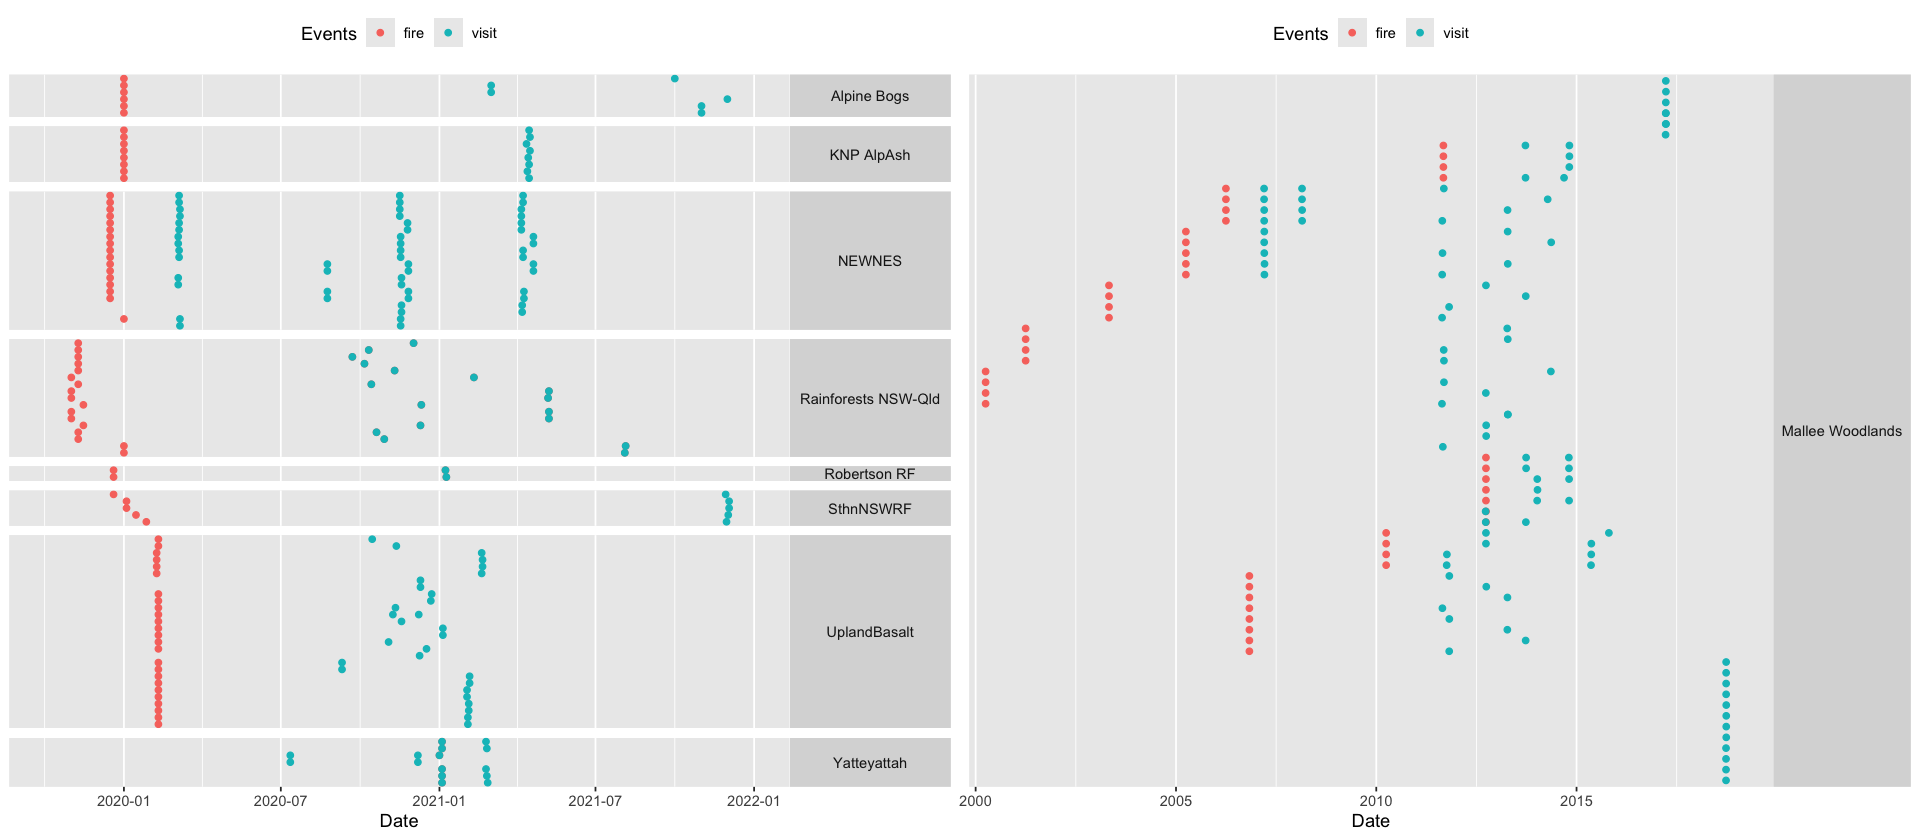

In [23]:
ggarrange(fire1,fire2)

## That is it for now!

✅ Job done! 😎👌🔥

You can:
- go [back home](../Instructions-and-workflow.ipynb),
- continue navigating the repo on [GitHub](https://github.com/ces-unsw-edu-au/fireveg-db-exports)
- continue exploring the repo on [OSF](https://osf.io/h96q2/).
- visit the database at <http://fireecologyplants.net>

### R session information

In [24]:
date()

[1] "Sat Jan 25 19:18:01 2025"

In [25]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: aarch64-apple-darwin20 (64-bit)
Running under: macOS 15.2

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRblas.0.dylib 
LAPACK: /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

time zone: Australia/Sydney
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggpubr_0.6.0      ggrepel_0.9.4     ozmaps_0.4.5      tidyr_1.3.0      
[5] sf_1.0-19         data.table_1.15.0 dplyr_1.1.4       forcats_1.0.0    
[9] ggplot2_3.5.0    

loaded via a namespace (and not attached):
 [1] s2_1.1.7           utf8_1.2.4         generics_0.1.3     rstatix_0.7.2     
 [5] class_7.3-22       KernSmooth_2.23-22 digest_0.6.37      magrittr_2.0.3    
 [9] evaluate_1.0.3     grid_4.3.1     